# **Clustering**

El primer paso es realizar un análisis de segmentación para agrupar clientes o productos según características clave.

In [1]:
%load_ext autoreload
%autoreload 2


# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("../../")
from src import funciones_eda as fe
from src import soporte_clustering as sc
from src import funciones_encoding as fen
from src import funciones_outliers as fo
from src import funciones_estandarizacion as fes

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../../datos/Global_Superstore.csv", encoding="latin1")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


Observamos que no hay dupolicados y la única columna que tiene nulos es Postal Code:

In [3]:
print(f"Hay {df.duplicated().sum()} duplicados.")
df.isna().sum()

Hay 0 duplicados.


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Vamos a eliminar las columnas que no aportan valor a la hora de segmentar los clientes. Entre ellas la columna que consideramos más importante es `Profit` pues nosotros como empresa lo que vamos a intentar es segmentar a nuestros clientes en base al dinero que nos están generando como empresa.

In [4]:
df_clustering = df[['Segment', 'Country', 'Category', 'Sales', 'Profit', 'Order Priority']]

In [5]:
fe.exploracion_dataframe(df_clustering)

El número de datos es 51290 y el de columnas es 6

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 1152

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Segment,object
Country,object
Category,object
Sales,float64
Profit,float64
Order Priority,object



 ..................... 



,count,mean,std,min,25%,50%,75%,max
Sales,51290.0,246.490581,487.565361,0.444,30.758625,85.053,251.0532,22638.480
Profit,51290.0,28.610982,174.340972,-6599.978,0.000000,9.240,36.8100,8399.976



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna SEGMENT tiene las siguientes valore únicos:


,count
Segment,
Consumer,26518
Corporate,15429
Home Office,9343


La columna COUNTRY tiene las siguientes valore únicos:


,count
Country,
United States,9994
Australia,2837
France,2827
Mexico,2644
Germany,2065


La columna CATEGORY tiene las siguientes valore únicos:


,count
Category,
Office Supplies,31273
Technology,10141
Furniture,9876


La columna ORDER PRIORITY tiene las siguientes valore únicos:


,count
Order Priority,
Medium,29433
High,15501
Critical,3932
Low,2424


Podemos observar que han aparecido duplicados debido a que hemos eliminado numerosas columnas, sin embargo, esos duplicados corresponden a datos reales por lo que los mantenemos. 

Vemos que tanto la media como mediana de las variables numéricas difieren bastante siendo en Sales 85 la mediana y 246 la media, lo que implica que hay alguno valores muy muy altos que distorsionan la media, lo mismo ocurre con Profit.

### 1. Visualizar numéricas y categóricas.

In [6]:
sop_clust = sc.Exploracion(df_clustering)

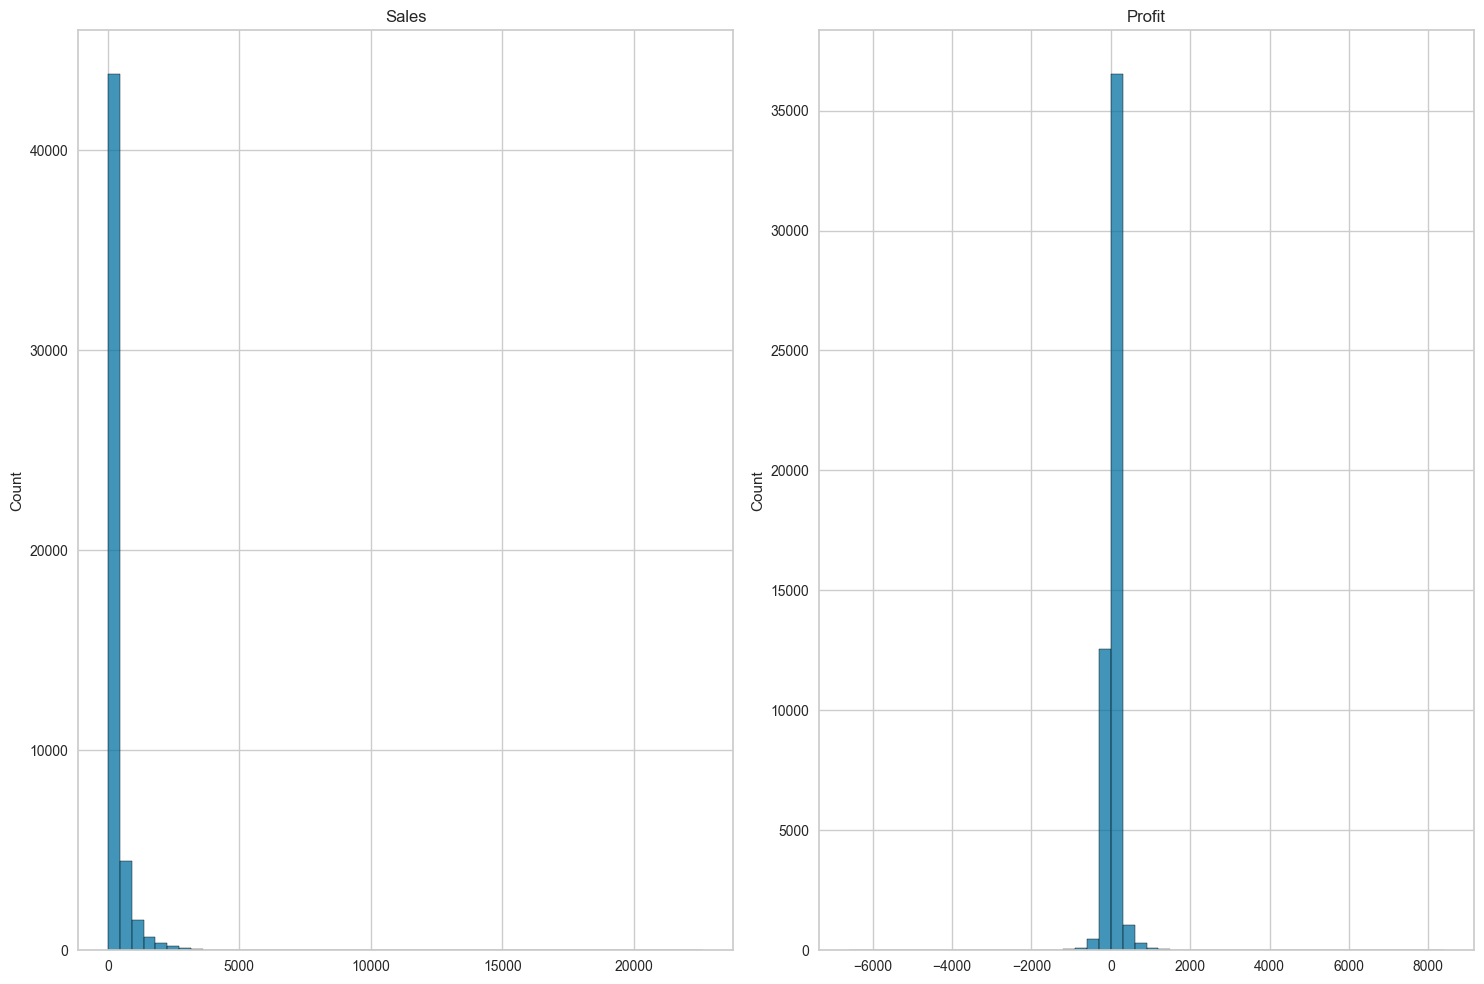

In [7]:
df_num, df_cat = fe.separar_df(df_clustering)
fe.plot_numericas(df_num)

Podemos observar gráficamente lo que acabamos de comentar sobre la media y la mediana y como hay valores donde hay muchísimo más peso que en otras haciendo que la media sea poco fiable.

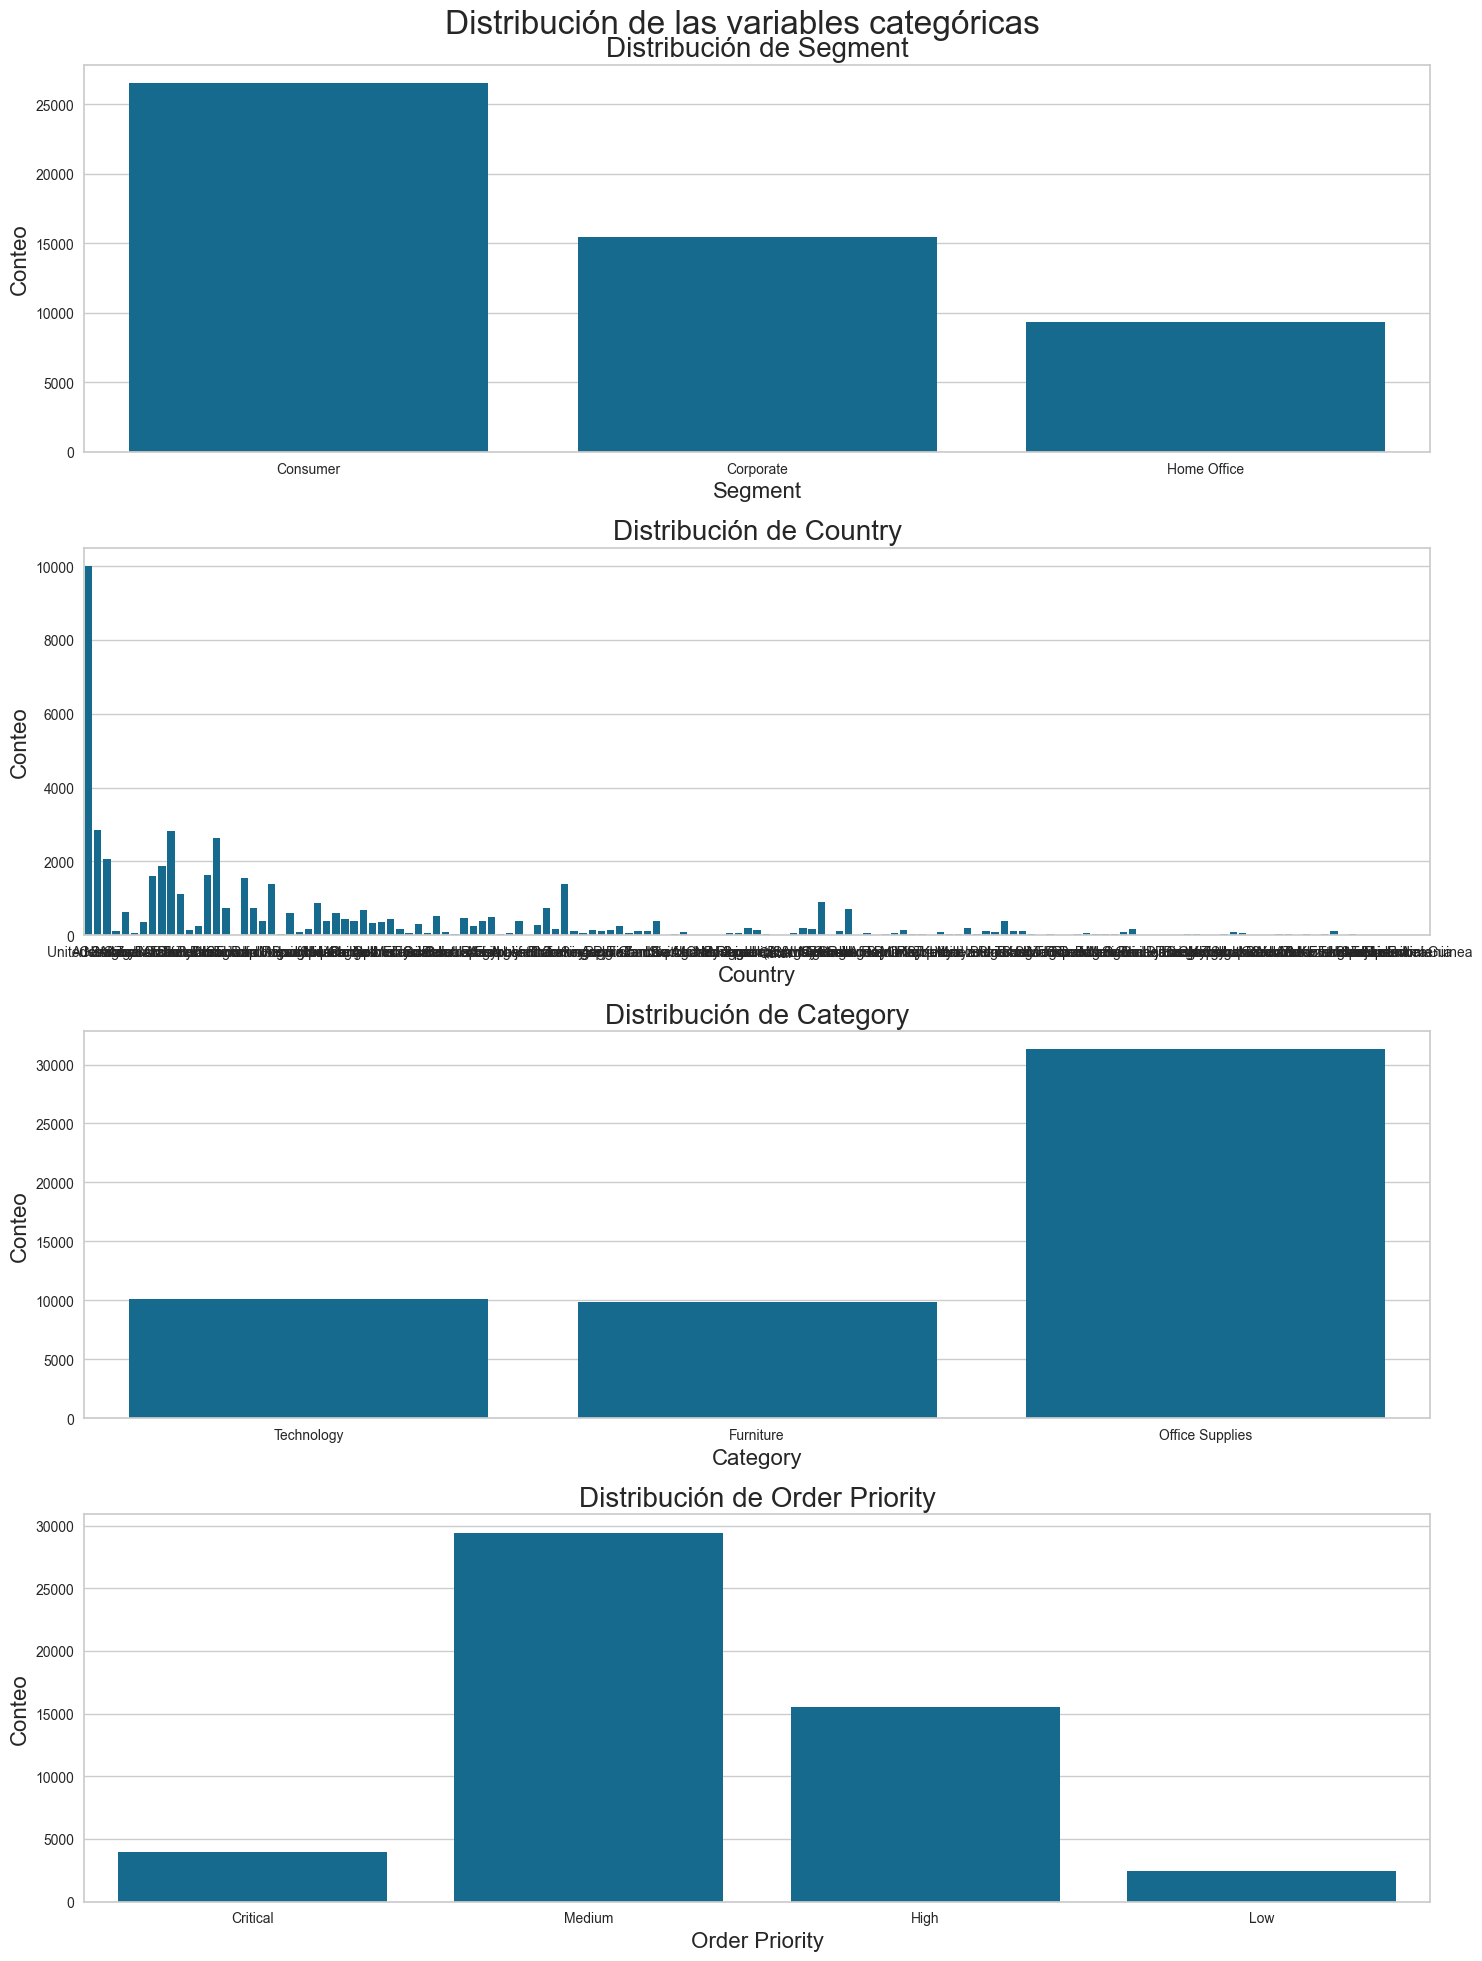

In [8]:
sop_clust.visualizar_categoricas()

En cuanto a las variables categóricas podemos ver que en Segment la variable consumer es la dominante, en cuanto a paises claramente hay muchísimos más clientes de Estados Unidos que de otros paises lo que puede generarnos demasiados clusters debido a sus distintos hábitos de compra. En cuanto a Category la más vendidad es Office Supllies y en cuanto a Order Priority la más usada es medium seguida de high.

### 2. Correlación entre variables numéricas

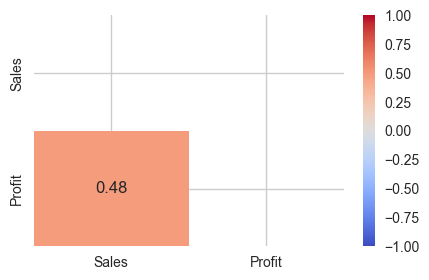

In [9]:
fe.heatmap_correlacion(df_clustering, figsize=(5,3))

La correlación entre Sales y Profit es mediana, de hecho estudiando los datos la categoría que más sales genera es la que menos profit da, no en todas es así, pero es una buena observación para entender porque la correlación no es más alta.

### 3. Outliers

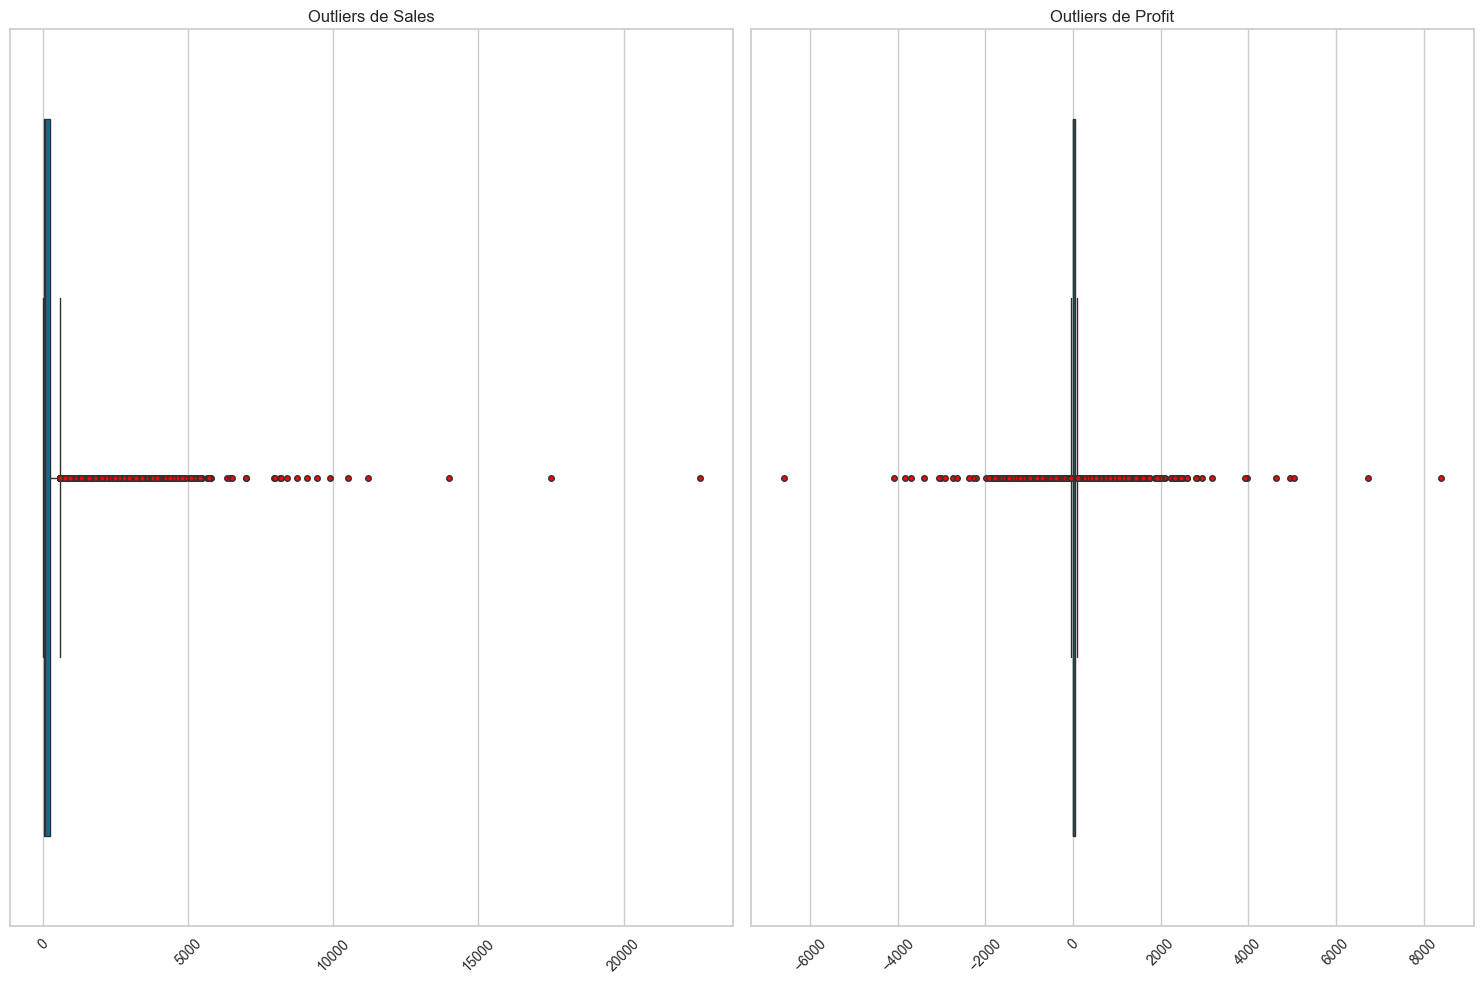

In [10]:
fe.detectar_outliers(df_clustering)

In [11]:
multi = fo.GestionOutliersMultivariados(df_clustering)
contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 200]
cols = df_num.columns
vr = ""
df_outliers = multi.detectar_outliers_if(cols, vr, contaminacion, estimadores, False)

In [12]:
df_outliers["porcentaje_outliers"] = df_outliers.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

porcentaje = 0.6
df_outliers_porcentaje = df_outliers[df_outliers["porcentaje_outliers"]>porcentaje]
df_restante = df_outliers[df_outliers["porcentaje_outliers"]<porcentaje]

print(f"Tenemos un {round(df_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

Tenemos un 4.46% de outliers respecto al total de los datos.


In [13]:
df_outliers_porcentaje.shape[0]

2289

In [14]:
df_outliers_porcentaje.describe().T[:2]

,count,mean,std,min,25%,50%,75%,max
Sales,2289.0,1737.307585,1307.948010,63.474,959.760,1564.5600,2182.68,22638.480
Profit,2289.0,164.083378,748.850891,-6599.978,-324.864,309.4515,553.98,8399.976


In [15]:
df_outliers_porcentaje["Category"].value_counts()


Category
Technology         946
Furniture          884
Office Supplies    459
Name: count, dtype: int64

In [16]:
df_outliers_porcentaje["Country"].value_counts()


Country
United States    363
Australia        172
China            137
France           123
India            110
                ... 
Estonia            1
Sudan              1
Hong Kong          1
Bolivia            1
Uganda             1
Name: count, Length: 104, dtype: int64

Observando los outlies al fin y al cabo son datos reales y tampoco deberíamos eliminarlos a la ligera por lo que como primera aproximación nos los quedamos.

In [17]:
df_inicial = df_clustering.copy()

In [ ]:
df_inicial.to_pickle("../../datos/dataframes/df_inicial.pkl")

## **Preprocesamiento**

### Encoding

In [19]:
df_clustering.head(1)

,Segment,Country,Category,Sales,Profit,Order Priority
0,Consumer,United States,Technology,2309.65,762.1845,Critical


In [20]:
diccionario_encoding={"onehot":['Category'], "frequency":['Segment', "Profit", 'Country', 'Order Priority']}
var = "Profit"
encoding = fen.Encoding(df_clustering, diccionario_encoding, var)


df_ohe, one_hot_encoder = encoding.one_hot_encoding()
df_ohe.drop(columns=diccionario_encoding["onehot"], inplace=True)
df_ohe

df_scaled = encoding.frequency_encoding()
df_scaled.head(3)


,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,0.517021,0.194853,2309.650,0.000019,0.076662,0.0,0.0,1.0
1,0.300819,0.055313,3709.395,0.000019,0.076662,1.0,0.0,0.0
2,0.517021,0.055313,5175.171,0.000019,0.573855,0.0,0.0,1.0


In [ ]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

### Estandarizacion

In [ ]:
df_clustering_encoded = pd.read_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

In [23]:
modelos_estand = ["standar", "robust", "minmax"]

df_estand, dic_scaler = fes.estandarizacion(df_clustering_encoded, df_clustering_encoded.columns, modelos_estand)
df_estand.head()

,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_standar,Country_standar,Sales_standar,Profit_standar,Order Priority_standar,Category_Furniture_standar,Category_Office Supplies_standar,Category_Technology_standar,Segment_robust,Country_robust,Sales_robust,Profit_robust,Order Priority_robust,Category_Furniture_robust,Category_Office Supplies_robust,Category_Technology_robust,Segment_minmax,Country_minmax,Sales_minmax,Profit_minmax,Order Priority_minmax,Category_Furniture_minmax,Category_Office Supplies_minmax,Category_Technology_minmax
0,0.517021,0.194853,2309.650,0.000019,0.076662,0.0,0.0,1.0,0.924087,1.973754,4.231596,-0.220113,-1.929401,-0.488334,-1.249929,2.014370,0.000000,3.643782,10.098283,-0.181818,-1.83039,0.0,-1.0,1.0,1.000000,1.000000,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.300819,0.055313,3709.395,0.000019,0.076662,1.0,0.0,0.0,-0.661092,-0.036474,7.102511,-0.220113,-1.929401,2.047779,-1.249929,-0.496433,-1.000000,0.553541,16.452253,-0.181818,-1.83039,1.0,-1.0,0.0,0.354352,0.283727,0.163837,0.0,0.055833,1.0,0.0,0.0
2,0.517021,0.055313,5175.171,0.000019,0.573855,0.0,0.0,1.0,0.924087,-0.036474,10.108857,-0.220113,0.795092,-0.488334,-1.249929,2.014370,0.000000,0.553541,23.105962,-0.181818,0.00000,0.0,-1.0,1.0,1.000000,0.283727,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.182160,0.040261,2892.510,0.000019,0.573855,0.0,0.0,1.0,-1.531089,-0.253310,5.427057,-0.220113,0.795092,-0.488334,-1.249929,2.014370,-1.548832,0.220207,12.744104,-0.181818,0.00000,0.0,-1.0,1.0,0.000000,0.206465,0.127753,0.0,1.000000,0.0,0.0,1.0
4,0.517021,0.002184,2832.960,0.000019,0.076662,0.0,0.0,1.0,0.924087,-0.801860,5.304919,-0.220113,-1.929401,-0.488334,-1.249929,2.014370,0.000000,-0.623057,12.473784,-0.181818,-1.83039,0.0,-1.0,1.0,1.000000,0.011009,0.125122,0.0,0.055833,0.0,0.0,1.0


In [24]:
scaler="minmax"
df_scaled = df_estand.loc[:, df_estand.columns.str.contains(f"{scaler}", case=False)]
df_scaled.columns = df_scaled.columns.str.replace(f"_{scaler}", "", regex=False)

df_scaled.head(2)


,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,1.000000,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,0.283727,0.163837,0.0,0.055833,1.0,0.0,0.0


In [ ]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")

# **Modelos de clustering**

In [ ]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,1.000000,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,0.283727,0.163837,0.0,0.055833,1.0,0.0,0.0
2,1.000000,0.283727,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.000000,0.206465,0.127753,0.0,1.000000,0.0,0.0,1.0
4,1.000000,0.011009,0.125122,0.0,0.055833,0.0,0.0,1.0


In [27]:
clust = sc.Clustering(df)
#clust.sacar_clusters_kmeans()

In [28]:
k=3
df_kmeans, labels = clust.modelo_kmeans(df, k)
display(df_kmeans.head())
clust.calcular_metricas(labels)

,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology,clusters_kmeans
0,1.000000,1.000000,0.102006,0.0,0.055833,0.0,0.0,1.0,1
1,0.354352,0.283727,0.163837,0.0,0.055833,1.0,0.0,0.0,2
2,1.000000,0.283727,0.228586,0.0,1.000000,0.0,0.0,1.0,1
3,0.000000,0.206465,0.127753,0.0,1.000000,0.0,0.0,1.0,1
4,1.000000,0.011009,0.125122,0.0,0.055833,0.0,0.0,1.0,1


,silhouette_score,davies_bouldin_index,cardinalidad
0,0.572761,0.716801,"{0: 31273, 1: 10141, 2: 9876}"


In [29]:
#clust.plot_clusters()

In [30]:
df_inicial["cluster_kmean"]=df_kmeans["clusters_kmeans"]
df_inicial.head()

,Segment,Country,Category,Sales,Profit,Order Priority,cluster_kmean
0,Consumer,United States,Technology,2309.650,762.1845,Critical,1
1,Corporate,Australia,Furniture,3709.395,-288.7650,Critical,2
2,Consumer,Australia,Technology,5175.171,919.9710,Medium,1
3,Home Office,Germany,Technology,2892.510,-96.5400,Medium,1
4,Consumer,Senegal,Technology,2832.960,311.5200,Critical,1


In [43]:
from math import ceil
ceil(len(df.columns)/3)

3

columna: Segment
columna: Country
columna: Category
columna: Order Priority
columna: cluster_kmean


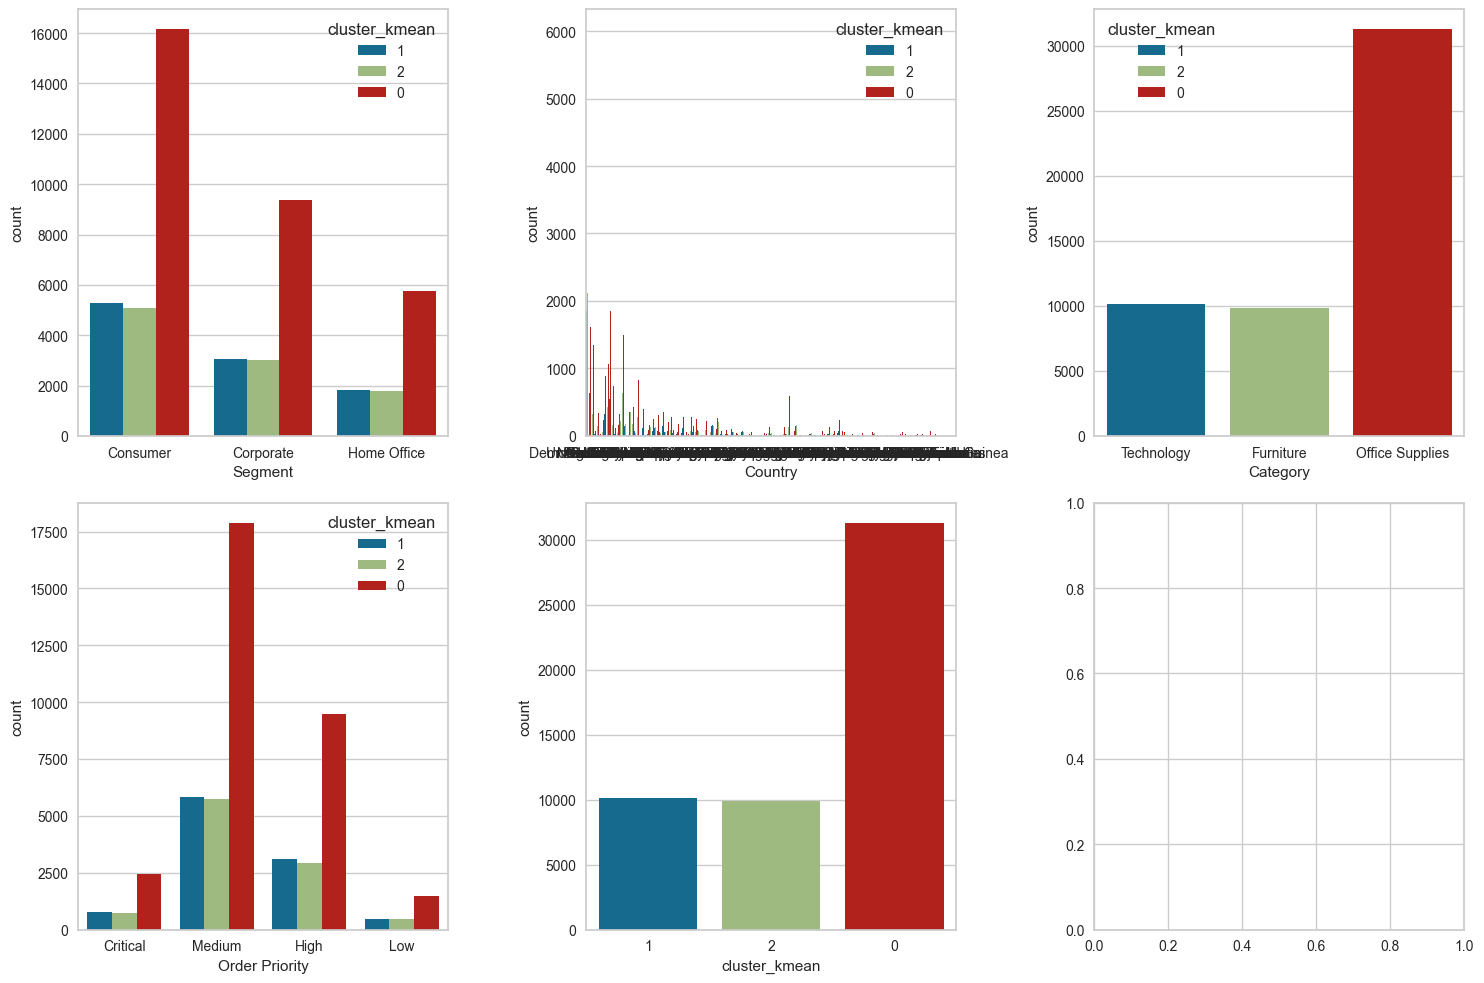

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

col_cat = df_inicial.select_dtypes(exclude=np.number).columns
#col_num = df_inicial.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=ceil(len(col_cat)/3), ncols=3, figsize=(15,10))
axes = axes.flat

for indice, col in enumerate(col_cat):
    print(f"columna: {col}")
    sns.countplot(df_inicial, x=col, hue="cluster_kmean", ax=axes[indice])

# for col_n in col_num:
#     indice += 1
#     print(f"columna: {col_n}")
#     sns.histplot(df_inicial, x=col_n, bins=10, hue="cluster_kmean", ax=axes[indice])

plt.tight_layout()
plt.show()

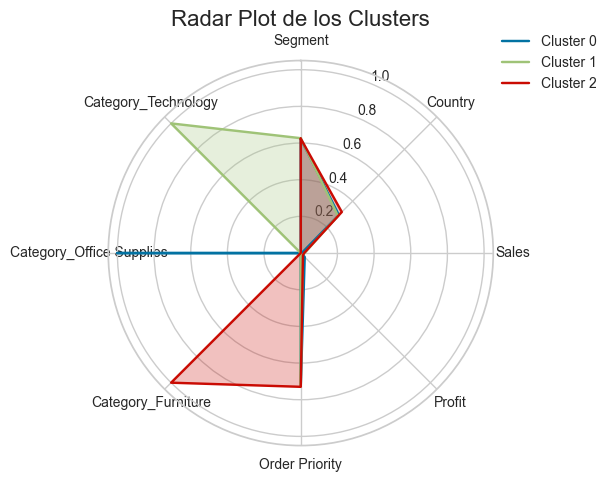

In [32]:
clust.radar_plot("kmeans", figsize=(5, 5))

# **Aglomerativo**

In [ ]:
cluster = sc.Clustering(df)

In [ ]:
df_aglomerativo = cluster.modelo_aglomerativo(clusters_min=2, clusters_max=5, linkage_methods = ['single', 'complete'], distance_metrics = ['euclidean'])

  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando single con euclidean y 2 clusters


 33%|███▎      | 1/3 [00:53<01:46, 53.31s/it]

Estoy ejecutando single con euclidean y 3 clusters


 67%|██████▋   | 2/3 [01:43<00:51, 51.56s/it]

Estoy ejecutando single con euclidean y 4 clusters


  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando complete con euclidean y 2 clusters


 33%|███▎      | 1/3 [09:10<18:21, 550.54s/it]

Estoy ejecutando complete con euclidean y 3 clusters


 67%|██████▋   | 2/3 [18:43<09:23, 563.75s/it]

Estoy ejecutando complete con euclidean y 4 clusters


100%|██████████| 3/3 [30:03<00:00, 601.33s/it]


In [35]:
df_aglomerativo

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
1,single,euclidean,0.502276,0.883333,"{0: 10141, 1: 9876, 2: 31273}",3
4,complete,euclidean,0.502276,0.883333,"{0: 10141, 1: 31273, 2: 9876}",3
5,complete,euclidean,0.474280,1.012096,"{0: 31273, 1: 10039, 2: 9876, 3: 102}",4
2,single,euclidean,0.474280,1.012096,"{0: 9876, 1: 102, 2: 31273, 3: 10039}",4
3,complete,euclidean,0.355517,1.142095,"{0: 41149, 1: 10141}",2
0,single,euclidean,0.352957,1.155943,"{0: 41414, 1: 9876}",2


In [38]:
df_aglomerativo_2 = cluster.modelo_aglomerativo(clusters_min=2, clusters_max=5, linkage_methods = ['ward'], distance_metrics = ['euclidean'])

  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando ward con euclidean y 2 clusters


 33%|███▎      | 1/3 [17:07<34:15, 1027.69s/it]

Estoy ejecutando ward con euclidean y 3 clusters


 67%|██████▋   | 2/3 [31:59<15:47, 947.96s/it] 

Estoy ejecutando ward con euclidean y 4 clusters


100%|██████████| 3/3 [40:23<00:00, 807.76s/it]


In [39]:
df_aglomerativo_2

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
1,ward,euclidean,0.497427,0.888377,"{0: 31489, 1: 9762, 2: 10039}",3
0,ward,euclidean,0.401244,1.298281,"{0: 19801, 1: 31489}",2
2,ward,euclidean,0.390381,1.124202,"{0: 19467, 1: 12022, 2: 10039, 3: 9762}",4


# **DBSCAN**

In [ ]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Segment,Country,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,1.000000,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,0.283727,0.163837,0.0,0.055833,1.0,0.0,0.0
2,1.000000,0.283727,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.000000,0.206465,0.127753,0.0,1.000000,0.0,0.0,1.0
4,1.000000,0.011009,0.125122,0.0,0.055833,0.0,0.0,1.0


In [61]:
cluster = sc.Clustering(df)

In [35]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[2000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
0,1.0,2000,0.502276,0.883333,"{0: 10141, 1: 9876, 2: 31273}"


best_eps: 1.0, best_min_samples: 2000


In [36]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[5000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
0,1.0,5000,0.551756,0.963226,"{-1: 40, 0: 9842, 1: 10135, 2: 31273}"


best_eps: 1.0, best_min_samples: 5000


In [37]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[1000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
0,1.0,1000,0.567208,0.798142,"{-1: 40, 0: 10135, 1: 9842, 2: 31273}"


best_eps: 1.0, best_min_samples: 1000


In [52]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5], min_samples_values=[2000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
0,0.5,2000,0.275448,1.139844,"{-1: 17292, 0: 2388, 1: 2332, 2: 5579, 3: 5005..."


best_eps: 0.5, best_min_samples: 2000


In [53]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5], min_samples_values=[1000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
0,0.5,1000,0.709076,0.702868,"{-1: 4600, 0: 2388, 1: 2332, 2: 1877, 3: 1656,..."


best_eps: 0.5, best_min_samples: 1000


In [64]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5], min_samples_values=[1000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
0,0.5,1000,0.574955,0.964796,"{-1: 4600, 0: 2388, 1: 2332, 2: 1877, 3: 1656,...",17


best_eps: 0.5, best_min_samples: 1000


In [56]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5, 1.0, 1.5, 2.0], min_samples_values=[1000, 2000, 5000, 10000])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
3,1.0,1000,0.817302,0.359237,"{-1: 635, 0: 1846, 1: 1564, 2: 2388, 3: 2332, ...",19
0,0.5,1000,0.791429,0.329758,"{-1: 4600, 0: 2388, 1: 2332, 2: 1877, 3: 1656,...",17
6,1.5,1000,0.558434,0.431441,"{0: 11197, 1: 1564, 2: 1598, 3: 1656, 4: 1261,...",10
10,2.0,5000,0.525874,0.462907,"{-1: 609, 0: 12853, 1: 18956, 2: 18872}",4
11,2.0,10000,0.487576,1.112057,"{-1: 18497, 0: 13147, 1: 19646}",3
7,1.5,2000,0.462634,2.193643,"{-1: 7836, 0: 11061, 1: 10584, 2: 2163, 3: 173...",6
4,1.0,2000,0.390366,1.867707,"{-1: 15202, 0: 2388, 1: 2332, 2: 5579, 3: 5005...",10
8,1.5,5000,0.365862,3.028379,"{-1: 15892, 0: 7459, 1: 10584, 2: 17355}",4
1,0.5,2000,0.332382,1.555966,"{-1: 17292, 0: 2388, 1: 2332, 2: 5579, 3: 5005...",9
9,1.5,10000,0.289141,2.394799,"{-1: 25520, 0: 10584, 1: 15186}",3


best_eps: 1.0, best_min_samples: 1000
